# Decentmon data preparation
This notebook is used to parse the data extracted from the Decentmon simulation and prepare it for further analysis.
Check the README.md for more information about how this file interacts with the others, and decent/README.md for the Decentmon output format.
The entire notebook is configurable, and based on the idea of the input being stored in the `input` directory, in folders named by the simulation number of nodes (the `SUBDIR` variable).

In [1]:
import pandas as pd

from decmon.constants import *
from decmon.df_utils import *
from decmon.filter import *
from decmon.plotter import *

In [2]:
SUBDIR = 9

## Data Loading
This section is responsible for loading the data from the simulation logs.

Each log correspond to a single formula pattern (i.e. the formulae are randomly generated according to this pattern), 

which is respectively loaded in a pandas DataFrame.

In [3]:
path = f"{INPUT_DIR}/{SUBDIR}"

f_df = [load_simulation_data(f"{path}/{i+1}_output.log") for i in PATTERNS]
f_df[0].head()

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,5018,1,2,3,2,9,8,0,1.0,2.22,0.0,4,10,4,"Ev (Var ""c"")",{a| | |d|e|f| | |i} ; {a| |c|d| |f|g|h| } ; {...
1,5018,1,3,4,3,18,8,0,1.0,1.48,0.0,6,20,6,"Ev (Var ""c"")",{ | | | | |f|g|h| } ; { | | |d|e| |g| |i} ; {...
2,5018,1,2,3,3,9,9,2,1.0,4.16,1.0,8,23,12,"Until (Var ""e"", Var ""f"")",{a| |c| |e| | |h| } ; {a| |c| |e|f|g| | } ; {...
3,5018,1,2,3,2,9,8,0,1.0,2.22,0.0,4,14,4,"Glob (Var ""e"")",{a|b| |d|e| | |h|i} ; {a| |c|d| |f| | | } ; {...
4,5018,1,2,3,2,9,0,0,1.0,0.00,0.0,3,9,3,"Next (Var ""h"")",{a| |c| | | | | | } ; {a|b| |d|e|f| |h|i} ; {...


Now, `f_df` is a list of DataFrames, one for each pattern, but 

where each metric (trace_len, num_mess, size_mess, nb_progression) is replicated for each strategy (orchestration, migration, choreography).

We prefer to have these column once, and an extra column to identify/label the strategy:

In [4]:
strategies_f_df = [split_by_dictionary(f_df[i], STRATEGIES) for i in PATTERNS] # now a list of lists of DataFrames (one for each strategy, for each pattern)
print(f"Datasets: {len(strategies_f_df)}. Strategies: {len(strategies_f_df[0])}. Single dataset Formulae:{len(strategies_f_df[0][0])}")
sep_strat_f_df = [pd.concat(strategies_f_df[i], ignore_index=True) for i in PATTERNS] # now a list of DataFrames (one for each pattern), with an extra column for the strategy
sep_strat_f_df[0].head()

Datasets: 8. Strategies: 3. Single dataset Formulae:5018


,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,5018,1,2,9,1.0,4,"Ev (Var ""c"")",{a| | |d|e|f| | |i} ; {a| |c|d| |f|g|h| } ; {...,orchestration
1,5018,1,3,18,1.0,6,"Ev (Var ""c"")",{ | | | | |f|g|h| } ; { | | |d|e| |g| |i} ; {...,orchestration
2,5018,1,2,9,1.0,8,"Until (Var ""e"", Var ""f"")",{a| |c| |e| | |h| } ; {a| |c| |e|f|g| | } ; {...,orchestration
3,5018,1,2,9,1.0,4,"Glob (Var ""e"")",{a|b| |d|e| | |h|i} ; {a| |c|d| |f| | | } ; {...,orchestration
4,5018,1,2,9,1.0,3,"Next (Var ""h"")",{a| |c| | | | | | } ; {a|b| |d|e|f| |h|i} ; {...,orchestration


Lastly, in preparation for a learning stage, we separate the metrics as pairs of: 

(metric, value) -> where the first is the name of the metric, and the second is the actual value

In [5]:
merged_metrics_df = [extract_metrics(sep_strat_f_df[i]) for i in PATTERNS]
merged_metrics_df[0]

,formula_id,strategy,value,metric
0,5018,orchestration,2.0,trace_len
1,5018,orchestration,3.0,trace_len
2,5018,orchestration,2.0,trace_len
3,5018,orchestration,2.0,trace_len
4,5018,orchestration,2.0,trace_len
...,...,...,...,...
15049,5018,choreography,659.0,nb_progressions
15050,5018,choreography,225.0,nb_progressions
15051,5018,choreography,534.0,nb_progressions
15052,5018,choreography,1493.0,nb_progressions


## Formula Encoding
We now procede to encode the formulae (and traces, if of interest).

In our case the `urgency` encoding has been selected, but alternative ones could be injected

In [6]:
def encode_normalize(df):
    return extract_ops(normalize_ops(df), encoding='urgency')


df_f_ops = [encode_normalize(sep_strat_f_df[i]) for i in PATTERNS]
df_f_ops[0].head()

,0,1,2,3,4,5,6,7,8,9,...,413,414,415,416,417,418,419,420,421,422
0,2,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2,0,1.0,-1.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The encoded formulae are then combined with the rest of the data previously collected.

In [7]:
expanded_f_df = [sep_strat_f_df[i].merge(df_f_ops[i], left_index=True, right_index=True) for i in PATTERNS]
expanded_f_df[0].head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,413,414,415,416,417,418,419,420,421,422
0,5018,1,2,9,1.0,4,"Ev (Var ""c"")",{a| | |d|e|f| | |i} ; {a| |c|d| |f|g|h| } ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5018,1,3,18,1.0,6,"Ev (Var ""c"")",{ | | | | |f|g|h| } ; { | | |d|e| |g| |i} ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5018,1,2,9,1.0,8,"Until (Var ""e"", Var ""f"")",{a| |c| |e| | |h| } ; {a| |c| |e|f|g| | } ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5018,1,2,9,1.0,4,"Glob (Var ""e"")",{a|b| |d|e| | |h|i} ; {a| |c|d| |f| | | } ; {...,orchestration,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5018,1,2,9,1.0,3,"Next (Var ""h"")",{a| |c| | | | | | } ; {a|b| |d|e|f| |h|i} ; {...,orchestration,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lastly, we add a `strategy_id` column that maps the `strategy` labels to numerical ids, 

and we combine all the pattern-based DataFrames into a single one, named `full_scale_df_n`.

In [8]:
for i in PATTERNS:
    expanded_f_df[i].strategy = pd.Categorical(expanded_f_df[i].strategy)
    expanded_f_df[i]['strategy_id'] = expanded_f_df[i].strategy.cat.codes

full_scale_df_9 = pd.concat(expanded_f_df)
full_scale_df_9.head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,861,862,863,864,865,866,867,868,869,870
0,5018,1,2,9,1.0,4,"Ev (Var ""c"")",{a| | |d|e|f| | |i} ; {a| |c|d| |f|g|h| } ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5018,1,3,18,1.0,6,"Ev (Var ""c"")",{ | | | | |f|g|h| } ; { | | |d|e| |g| |i} ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5018,1,2,9,1.0,8,"Until (Var ""e"", Var ""f"")",{a| |c| |e| | |h| } ; {a| |c| |e|f|g| | } ; {...,orchestration,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5018,1,2,9,1.0,4,"Glob (Var ""e"")",{a|b| |d|e| | |h|i} ; {a| |c|d| |f| | | } ; {...,orchestration,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5018,1,2,9,1.0,3,"Next (Var ""h"")",{a| |c| | | | | | } ; {a|b| |d|e|f| |h|i} ; {...,orchestration,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting
Extra plots that are provided to give some visual insights about the data

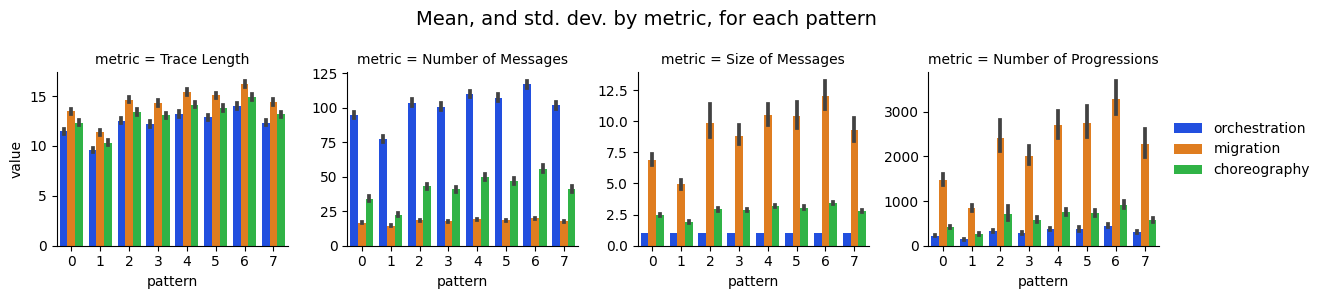

In [9]:
merged_metrics_dfp = prepare_with_pattern(merged_metrics_df)
plot = plot_metrics_by_patterns(merged_metrics_dfp)
plot.savefig(f"output/pattern_{SUBDIR}.png")
plot